In [1]:
import numpy as np 
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pylab as plt

In [ ]:
def sigmoid(x): 
    return 1.0/(1+np.exp(-x))

def relu(x): 
    return x*(x >=0)

def lrelu(x): 
    r = np.ones(len(x))
    r[x<=0] = 0.05
    return x*r

In [ ]:
x = np.linspace(-3, 3, 1000)

plt.figure(dpi=500)
plt.plot(x, relu(x), 'r', label='Relu')
plt.plot(x, lrelu(x), 'k', label='LeakyRelu')
plt.plot(x, sigmoid(x), 'b', label='Sigmoid')
plt.plot(x, np.tanh(x), 'g', label='Tanh')
plt.ylim([-1.5, 1.5])
plt.legend()
plt.savefig('pdf/nn-activation.pdf')

In [ ]:
x = np.linspace(-3, 3, 1000)

plt.figure(dpi=500)
plt.plot(x, sigmoid(x), 'r', label='f(x)')
plt.plot(x, sigmoid(x)*(1-sigmoid(x)), 'k', label='df(x)/dx')
plt.plot([-3, 3], [.25, .25], c='b', linestyle='dotted')
plt.legend()
plt.savefig('pdf/nn-sigmoid.pdf')

In [2]:
n_epochs = 3
batch_size_train = 64
batch_size_test = 1000
learning_rate = 0.01
momentum = 0.5
log_interval = 10

random_seed = 1
torch.backends.cudnn.enabled = False
torch.manual_seed(random_seed)

train_loader = torch.utils.data.DataLoader(
  torchvision.datasets.MNIST('/files/', train=True, download=True,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize(
                                 (0.1307,), (0.3081,))
                             ])),
  batch_size=batch_size_train, shuffle=True)

test_loader = torch.utils.data.DataLoader(
  torchvision.datasets.MNIST('/files/', train=False, download=True,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize(
                                 (0.1307,), (0.3081,))
                             ])),
  batch_size=batch_size_test, shuffle=True)

examples = enumerate(test_loader)
batch_idx, (example_data, example_targets) = next(examples)

In [ ]:
fig = plt.figure(dpi=500)
for i in range(6):
  plt.subplot(2,3,i+1)
  plt.tight_layout()
  plt.imshow(example_data[i][0], cmap='gray', interpolation='none')
  plt.title("Ground Truth: {}".format(example_targets[i]))
  plt.xticks([])
  plt.yticks([])

plt.savefig('pdf/nn-mnist.pdf')

In [ ]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, 10)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = x.view(-1, 320)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return F.log_softmax(x)

    
network = Net()
optimizer = optim.SGD(network.parameters(), lr=learning_rate,
                      momentum=momentum)
train_losses = []
train_counter = []
test_losses = []
test_counter= [i*len(train_loader.dataset) for i in range(n_epochs + 1)]

def train(epoch):
  network.train()
  for batch_idx, (data, target) in enumerate(train_loader):
    optimizer.zero_grad()
    output = network(data)
    loss = F.nll_loss(output, target)
    loss.backward()
    optimizer.step()
    if batch_idx % log_interval == 0:
      #print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
      #  epoch, batch_idx * len(data), len(train_loader.dataset),
      #  100. * batch_idx / len(train_loader), loss.item()))
      train_losses.append(loss.item())
      train_counter.append(
        (batch_idx*64) + ((epoch-1)*len(train_loader.dataset)))
      #torch.save(network.state_dict(), '/results/model.pth')
      #torch.save(optimizer.state_dict(), '/results/optimizer.pth')

def test():
  network.eval()
  test_loss = 0
  correct = 0
  with torch.no_grad():
    for data, target in test_loader:
      output = network(data)
      test_loss += F.nll_loss(output, target, size_average=False).item()
      pred = output.data.max(1, keepdim=True)[1]
      correct += pred.eq(target.data.view_as(pred)).sum()
  test_loss /= len(test_loader.dataset)
  test_losses.append(test_loss)
  print('\nTest set: Avg. loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
    test_loss, correct, len(test_loader.dataset),
    100. * correct / len(test_loader.dataset)))

test()
for epoch in range(1, n_epochs + 1):
  train(epoch)
  test()

In [ ]:
fig = plt.figure(dpi=500)
plt.plot(train_counter, train_losses, color='blue')
plt.scatter(test_counter, test_losses, color='red')
plt.legend(['Train Loss', 'Test Loss'], loc='upper right')
plt.xlabel('number of training examples seen')
plt.ylabel('negative log likelihood loss')
plt.savefig('pdf/nn-mnist-loss-train.pdf')

C:\Users\grego\AppData\Local\Temp\ipykernel_12304\3081555581.py:17: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)
C:\Users\grego\anaconda3\lib\site-packages\torch\nn\_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


Test set: Avg. loss: 2.3124, Accuracy: 863/10000 (9%)
Test set: Avg. loss: 0.1689, Accuracy: 9514/10000 (95%)
Test set: Avg. loss: 0.1095, Accuracy: 9655/10000 (97%)
Test set: Avg. loss: 0.0930, Accuracy: 9718/10000 (97%)
Test set: Avg. loss: 2.3213, Accuracy: 1206/10000 (12%)
Test set: Avg. loss: 0.3058, Accuracy: 9180/10000 (92%)
Test set: Avg. loss: 0.1806, Accuracy: 9472/10000 (95%)
Test set: Avg. loss: 0.1418, Accuracy: 9569/10000 (96%)
Test set: Avg. loss: 2.3121, Accuracy: 673/10000 (7%)
Test set: Avg. loss: 2.2509, Accuracy: 1869/10000 (19%)
Test set: Avg. loss: 2.1574, Accuracy: 4699/10000 (47%)
Test set: Avg. loss: 1.9603, Accuracy: 6157/10000 (62%)
Test set: Avg. loss: 2.3013, Accuracy: 982/10000 (10%)
Test set: Avg. loss: 0.0988, Accuracy: 9690/10000 (97%)
Test set: Avg. loss: 0.0688, Accuracy: 9778/10000 (98%)
Test set: Avg. loss: 0.0572, Accuracy: 9810/10000 (98%)
Test set: Avg. loss: 2.3110, Accuracy: 1139/10000 (11%)
Test set: Avg. loss: 0.0834, Accuracy: 9736/10000 (97

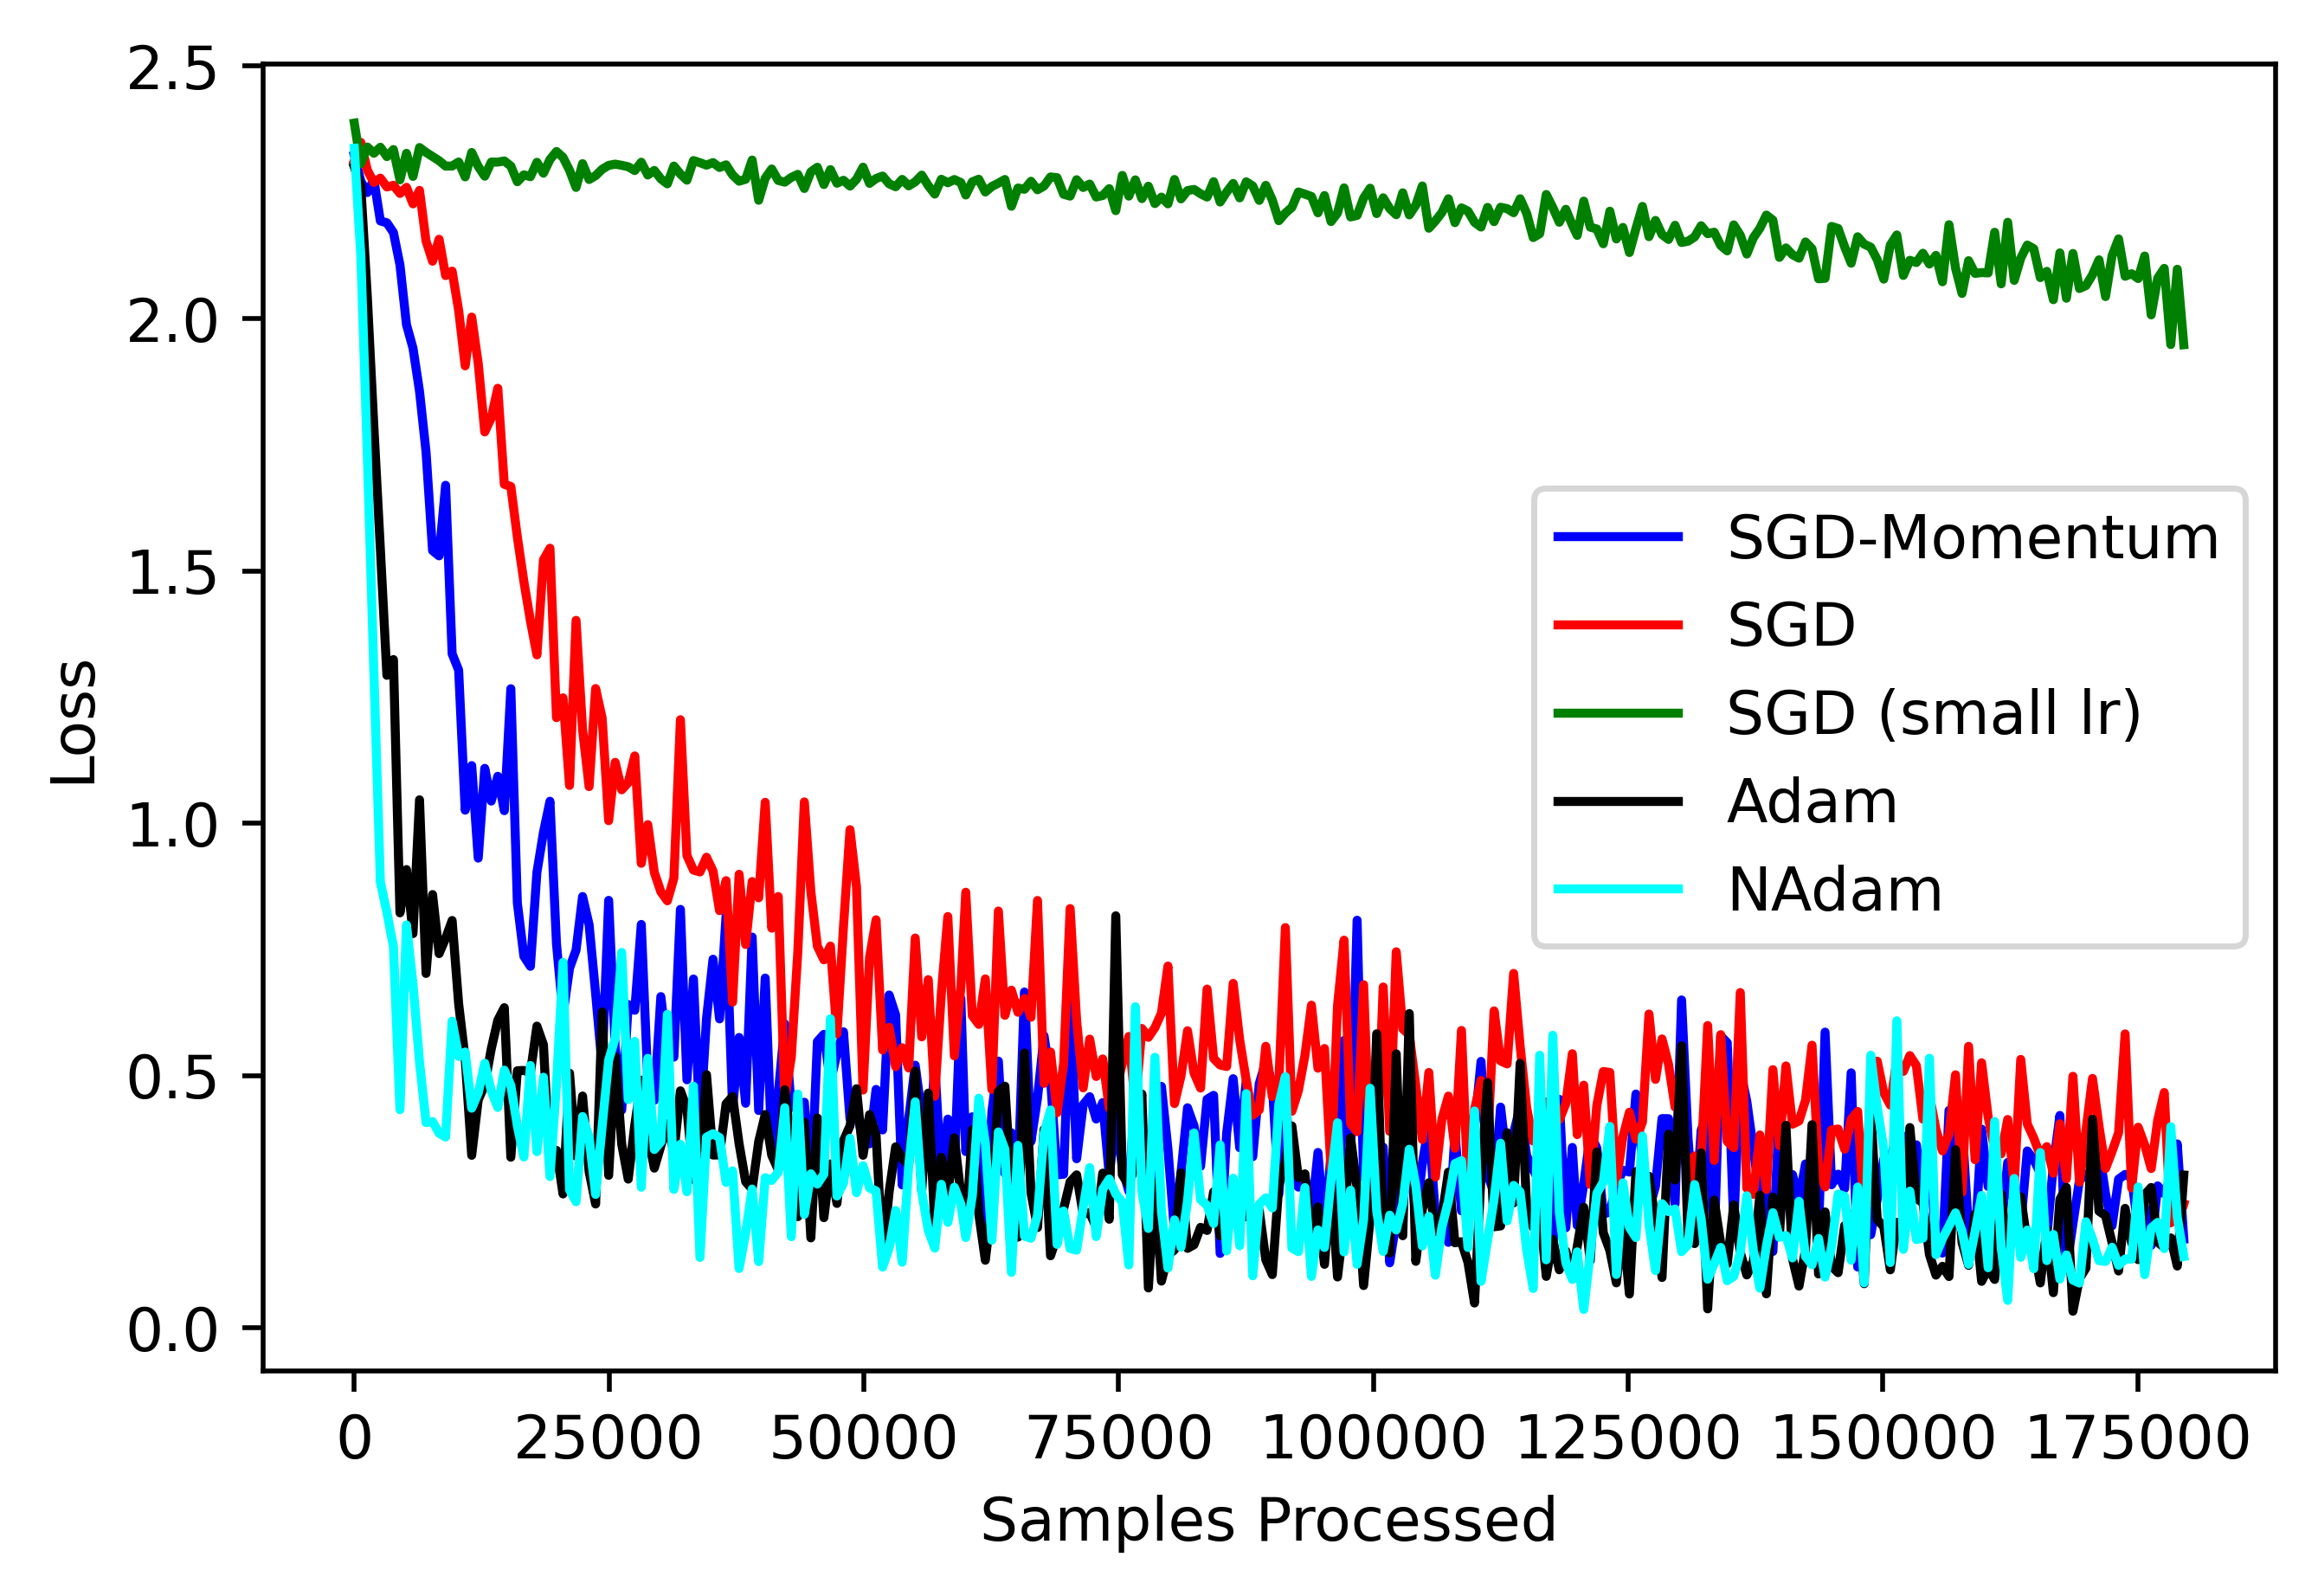

In [6]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, 10)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = x.view(-1, 320)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return F.log_softmax(x)

##################################################################################
network = Net()
optimizer = optim.SGD(network.parameters(), lr=learning_rate, momentum=momentum)

train_losses, train_counter, test_losses = [], [], []
test_counter= [i*len(train_loader.dataset) for i in range(n_epochs + 1)]


##################################################################################
##################################################################################
def train(epoch):
  network.train()
  for batch_idx, (data, target) in enumerate(train_loader):
    optimizer.zero_grad()
    output = network(data)
    loss = F.nll_loss(output, target)
    loss.backward()
    optimizer.step()
    if batch_idx % log_interval == 0:
      train_losses.append(loss.item())
      train_counter.append((batch_idx*64) + ((epoch-1)*len(train_loader.dataset)))

##################################################################################
##################################################################################
def test():
  network.eval()
  test_loss = 0
  correct = 0
  with torch.no_grad():
    for data, target in test_loader:
      output = network(data)
      test_loss += F.nll_loss(output, target, size_average=False).item()
      pred = output.data.max(1, keepdim=True)[1]
      correct += pred.eq(target.data.view_as(pred)).sum()
  test_loss /= len(test_loader.dataset)
  test_losses.append(test_loss)
  print('Test set: Avg. loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)'.format(test_loss, correct, 
                                                                        len(test_loader.dataset), 
                                                                        100. * correct / len(test_loader.dataset)))

test()
for epoch in range(1, n_epochs + 1):
  train(epoch)
  test()

fig = plt.figure(dpi=500)
plt.plot(train_counter, train_losses, color='blue', label='SGD-Momentum')



##################################################################################
network = Net()
optimizer = optim.SGD(network.parameters(), lr=learning_rate, momentum=0)

train_losses, train_counter, test_losses = [], [], []
test_counter = [i*len(train_loader.dataset) for i in range(n_epochs + 1)]

test()
for epoch in range(1, n_epochs + 1):
  train(epoch)
  test()
plt.plot(train_counter, train_losses, color='red', label='SGD')


##################################################################################
network = Net()
optimizer = optim.SGD(network.parameters(), lr=.0005, momentum=0)

train_losses, train_counter, test_losses = [], [], []
test_counter = [i*len(train_loader.dataset) for i in range(n_epochs + 1)]

test()
for epoch in range(1, n_epochs + 1):
  train(epoch)
  test()
plt.plot(train_counter, train_losses, color='green', label='SGD (small lr)')


##################################################################################
network = Net()
optimizer = optim.Adam(network.parameters())

train_losses, train_counter, test_losses = [], [], []
test_counter= [i*len(train_loader.dataset) for i in range(n_epochs + 1)]

test()
for epoch in range(1, n_epochs + 1):
  train(epoch)
  test()
plt.plot(train_counter, train_losses, color='black', label='Adam')


##################################################################################
network = Net()
optimizer = optim.NAdam(network.parameters())

train_losses, train_counter, test_losses = [], [], []
test_counter= [i*len(train_loader.dataset) for i in range(n_epochs + 1)]

test()
for epoch in range(1, n_epochs + 1):
  train(epoch)
  test()
plt.plot(train_counter, train_losses, color='cyan', label='NAdam')


plt.legend()
plt.xlabel('Samples Processed')
plt.ylabel('Loss')
plt.savefig('pdf/nn-optim.pdf')

In [ ]:
class Net2(nn.Module):
    def __init__(self, n_epochs=3, train_loader, optimizer):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, 10)
        self.n_epochs = n_epochs
        self.train_losses, self.train_counter, self.test_losses = [], [], []
        self.test_counter= [i*len(train_loader.dataset) for i in range(n_epochs + 1)]
        self.train_loader = train_loader
        self.optimizer = optimizer
        self.network = None 

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = x.view(-1, 320)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return F.log_softmax(x)
    
    def train_step(self, epoch):
        self.network.train()
        for batch_idx, (data, target) in enumerate(self.train_loader):
            self.optimizer.zero_grad()
            output = self.network(data)
            loss = F.nll_loss(output, target)
            loss.backward()
            optimizer.step()
            if batch_idx % log_interval == 0:
                train_losses.append(loss.item())
                train_counter.append((batch_idx*64) + ((epoch-1)*len(train_loader.dataset)))
    
    def run(): 

##################################################################################
network = Net()
optimizer = optim.SGD(network.parameters(), lr=learning_rate, momentum=momentum)

train_losses, train_counter, test_losses = [], [], []
test_counter= [i*len(train_loader.dataset) for i in range(n_epochs + 1)]


##################################################################################
##################################################################################
def train(epoch):
  network.train()
  for batch_idx, (data, target) in enumerate(train_loader):
    optimizer.zero_grad()
    output = network(data)
    loss = F.nll_loss(output, target)
    loss.backward()
    optimizer.step()
    if batch_idx % log_interval == 0:
      train_losses.append(loss.item())
      train_counter.append((batch_idx*64) + ((epoch-1)*len(train_loader.dataset)))

##################################################################################
##################################################################################
def test():
  network.eval()
  test_loss = 0
  correct = 0
  with torch.no_grad():
    for data, target in test_loader:
      output = network(data)
      test_loss += F.nll_loss(output, target, size_average=False).item()
      pred = output.data.max(1, keepdim=True)[1]
      correct += pred.eq(target.data.view_as(pred)).sum()
  test_loss /= len(test_loader.dataset)
  test_losses.append(test_loss)
  print('Test set: Avg. loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)'.format(test_loss, correct, 
                                                                        len(test_loader.dataset), 
                                                                        100. * correct / len(test_loader.dataset)))

test()
for epoch in range(1, n_epochs + 1):
  train(epoch)
  test()
